# who won in US president elections 2020? according to tweets

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import io
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from textblob import TextBlob
from nltk.util import ngrams
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-election-2020-tweets/hashtag_donaldtrump.csv
/kaggle/input/us-election-2020-tweets/hashtag_joebiden.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Import datasets

In [2]:
Trump_dataset = pd.read_csv('/kaggle/input/us-election-2020-tweets/hashtag_donaldtrump.csv', lineterminator='\n')
Biden_dataset = pd.read_csv('../input/us-election-2020-tweets/hashtag_joebiden.csv',lineterminator='\n')

In [3]:
Trump_dataset.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [4]:
Biden_dataset.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


Drop useles columns

In [5]:
Trump_dataset = Trump_dataset.drop(columns = ['tweet_id','collected_at','user_description','collected_at'])
Biden_dataset = Biden_dataset.drop(columns = ['tweet_id','collected_at','user_description','collected_at'])

In [6]:
Trump_dataset.loc[:,'condidat'] = 'Trump'
Biden_dataset.loc[:,'condidat'] = 'Biden'

In [7]:
Data_Mixed = pd.concat([Trump_dataset,Biden_dataset])
Data_Mixed.sort_values(by='created_at')
Data_Mixed.head()

,created_at,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,condidat
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,Trump
1,2020-10-15 00:00:01,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trump
2,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,Trump
3,2020-10-15 00:00:02,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trump
4,2020-10-15 00:00:08,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,2009-06-15 19:05:35,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,Trump


# Number of tweets

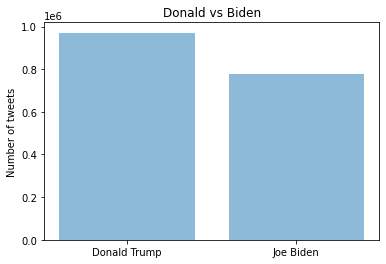

In [8]:
Trump_tweets = Data_Mixed.query('(condidat == "Trump")').tweet.sort_values(ascending=False).count()
Biden_tweets = Data_Mixed.query('(condidat == "Biden")').tweet.sort_values(ascending=False).count()

objects = ('Donald Trump','Joe Biden')
y_pos = np.arange(len(objects))
performance = [Trump_tweets,Biden_tweets]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of tweets')
plt.title('Donald vs Biden')

plt.show()

# Number of likes

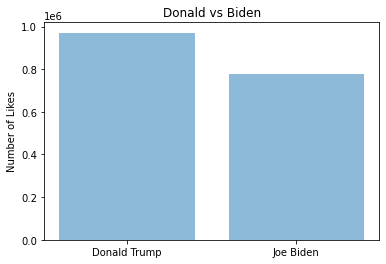

In [9]:
Trump_tweets = Data_Mixed.query('(condidat == "Trump")').likes.count()
Biden_tweets = Data_Mixed.query('(condidat == "Biden")').likes.count()

objects = ('Donald Trump','Joe Biden')
y_pos = np.arange(len(objects))
performance = [Trump_tweets,Biden_tweets]

plt.bar(y_pos, performance, align='center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Likes')
plt.title('Donald vs Biden')

plt.show()

# Tweets count in countries

Tweets count in country India

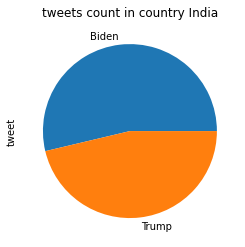

In [10]:
def Country_tweets(country,kind):
    Data=Data_Mixed[Data_Mixed.country == country].groupby('condidat').tweet.count()
    Data.plot(x = 'condidate',y = "tweet",kind = kind, title="tweets count in country " + str(country))
    
Country_tweets('India','pie')

Tweets count in Brazil

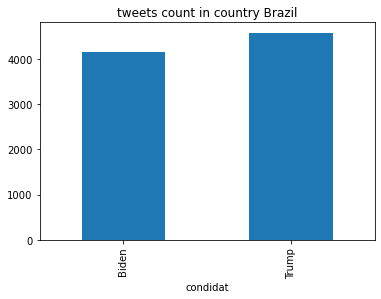

In [11]:
Country_tweets('Brazil','bar')

tweets count in France

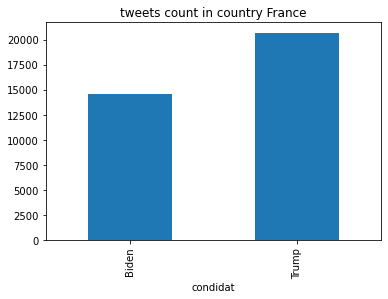

In [12]:
Country_tweets('France','bar')

Create class for chart building

In [13]:
class Chart_builder:
    
    def __init__(self,topic_index,number):
        super().__init__()
        self.topic_index = topic_index
        self.topics_list = ['source','country','state','continent','city']
        self.number      = number
        self.index = self.topics_list[self.topic_index]
        self.Trump_tweets_sources_x = Data_Mixed.query('(condidat == "Trump")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number].index
        
        self.Trump_tweets_sources_y = Data_Mixed.query('(condidat == "Trump")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number]
        
        self.Biden_tweets_sources_x = Data_Mixed.query('(condidat == "Biden")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number].index
        
        self.Biden_tweets_sources_y = Data_Mixed.query('(condidat == "Biden")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number]
    
    def Builder(self):
        fig = go.Figure([go.Bar(x = self.Trump_tweets_sources_x, y = self.Trump_tweets_sources_y, name = 'Trump'),
                         go.Bar(x = self.Biden_tweets_sources_x, y = self.Biden_tweets_sources_y, name = 'Biden')])
        # Customize aspect
        fig.update_layout(title_text = 'top '+ str(self.number) + ' ' + self.index)
        fig.update_xaxes(title = 'sources')
        fig.update_yaxes(title = 'tweets count')
        fig.show()

# Top 5 countries

In [14]:
# choose index for topic
topic_index = 1 # from class list its country

# number of elements in chart
number = 5 # it;s mean top five

launch = Chart_builder(topic_index,number)
launch.Builder()

# Top 10 sources

In [15]:
topic_index = 0
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()

# Top 10 states

In [16]:
topic_index = 2
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()

# Top 10 continent

In [17]:
topic_index = 3
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()

# Top 10 cities

In [18]:
topic_index = 4
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()

# Sentiment Analysis

Functions for Data Manipulation

In [19]:
def clean(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    return text

In [20]:
# create fuction to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score==0:
        return 'neutral'
    else:
        return 'positive'

# DonaldTrump tweets sentiment analysis

In [21]:
Trump_Tweets = Data_Mixed.query('(condidat == "Trump")').sort_values('user_followers_count',ascending = False).drop_duplicates(['user_name'])[['tweet','country']]
Trump_Tweets = Trump_Tweets.dropna().loc[Trump_Tweets.country == 'United States of America'][:1000]

Trump_Tweets.reset_index(inplace = True, drop = True)

Trump_Tweets['ClearTweet'] = Trump_Tweets['tweet'].apply(clean)

Trump_Tweets['subjectivity']= Trump_Tweets['ClearTweet'].apply(getSubjectivity)
Trump_Tweets['polarity']    = Trump_Tweets['ClearTweet'].apply(getPolarity)
Trump_Tweets['analysis']    = Trump_Tweets['polarity'].apply(getAnalysis)
Trump_Tweets.head()


Trump_Tweets.head()

,tweet,country,ClearTweet,subjectivity,polarity,analysis
0,"Without a doubt, the #FourSeasons debacle is t...",United States of America,without a doubt the fourseasons debacle is th...,0.483333,0.333333,positive
1,"President Donald #Trump’s youngest daughter, T...",United States of America,president donald trump s youngest daughter ti...,0.000000,0.000000,neutral
2,Woah. Have you read this article?\n\nAll the p...,United States of America,woah have you read this article all the presi...,0.000000,0.000000,neutral
3,The latest episode of #SNL tackled #DonaldTrum...,United States of America,the latest episode of snl tackled donaldtrump ...,0.800000,-0.033333,negative
4,🇺🇸 #Decision2020: @JoeBiden firmará una serie ...,United States of America,firmará una serie de órdenes ejecutivas ...,0.000000,0.000000,neutral


In [22]:
%%time
Trump_Tweets.polarity = Trump_Tweets.polarity.apply(lambda x: getAnalysis(x))

CPU times: user 2.86 ms, sys: 0 ns, total: 2.86 ms
Wall time: 2.52 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

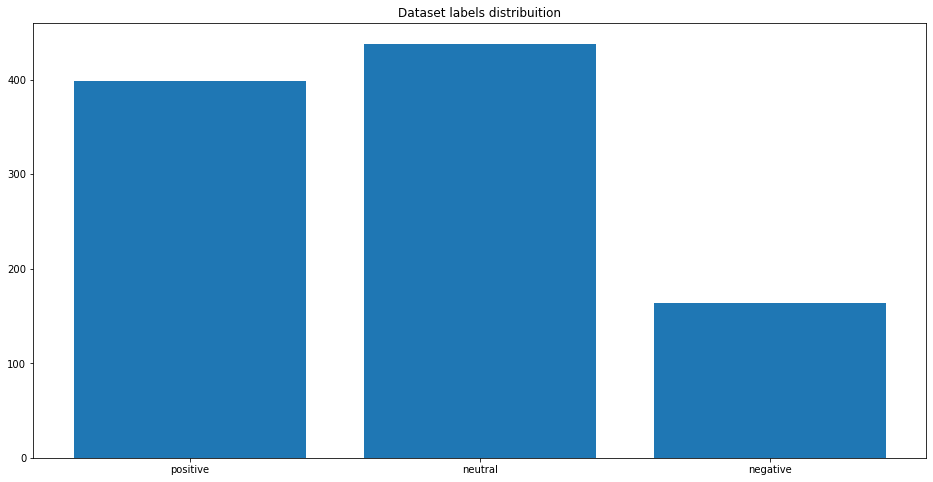

In [23]:
from collections import Counter

target_cnt = Counter(Trump_Tweets.polarity)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [24]:
general  = Trump_Tweets.groupby('analysis').analysis.count()
neutral  = Trump_Tweets[Trump_Tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = Trump_Tweets[Trump_Tweets['analysis'] == 'positive'].ClearTweet.count()
negative = Trump_Tweets[Trump_Tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positivity","negativity","neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='sentimat analysis tweets Donald Trump')
fig.show()

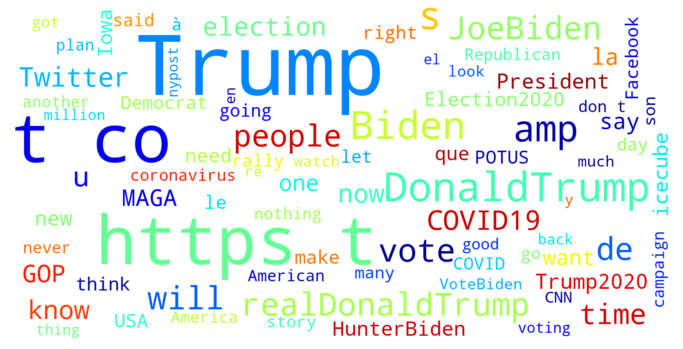

In [25]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(Trump_dataset['tweet'][0:1000])

# JoeBiden tweets sentiment analysis

In [26]:
Biden_Tweets = Data_Mixed.query('(condidat == "Biden")').sort_values('user_followers_count',ascending = False).drop_duplicates(['user_name'])[['tweet','country']]
Biden_Tweets = Biden_Tweets.dropna().loc[Biden_Tweets.country == 'United States of America'][:1000]


Biden_Tweets.reset_index(inplace = True, drop = True)

Biden_Tweets['ClearTweet'] = Biden_Tweets['tweet'].apply(clean)

 
Biden_Tweets['subjectivity']= Biden_Tweets['ClearTweet'].apply(getSubjectivity)
Biden_Tweets['polarity']    = Biden_Tweets['ClearTweet'].apply(getPolarity)
Biden_Tweets['analysis']    = Biden_Tweets['polarity'].apply(getAnalysis)
Biden_Tweets.head()


Biden_Tweets.head()

,tweet,country,ClearTweet,subjectivity,polarity,analysis
0,#JoeBiden is enlisting A-list star power to he...,United States of America,joebiden is enlisting a list star power to hel...,0.00,0.00,neutral
1,While we were campaigning across battleground ...,United States of America,while we were campaigning across battleground ...,0.75,0.80,positive
2,The big fight TODAY!!!!! @realDonaldTrump vs #...,United States of America,the big fight today vs joebiden who you ...,0.10,0.00,neutral
3,"During his victory speech, #JoeBiden said he u...",United States of America,during his victory speech joebiden said he un...,0.75,-0.75,negative
4,Los nueve minutos de colorida celebración tras...,United States of America,los nueve minutos de colorida celebración tras...,0.00,0.00,neutral


In [27]:
%%time
Biden_Tweets.polarity = Biden_Tweets.polarity.apply(lambda x: getAnalysis(x))

CPU times: user 1.54 ms, sys: 0 ns, total: 1.54 ms
Wall time: 1.55 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

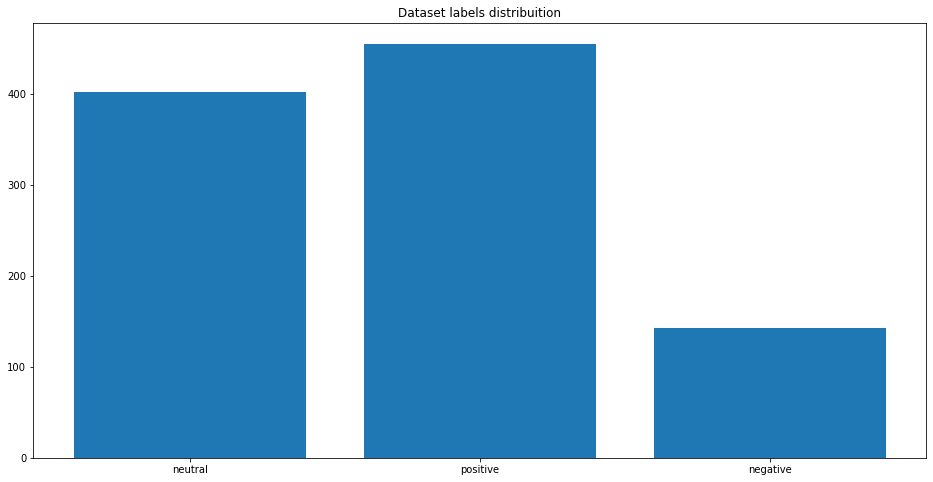

In [28]:
target_cnt = Counter(Biden_Tweets.polarity)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [29]:
general  = Biden_Tweets.groupby('analysis').analysis.count()
neutral  = Biden_Tweets[Biden_Tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = Biden_Tweets[Biden_Tweets['analysis'] == 'positive'].ClearTweet.count()
negative = Biden_Tweets[Biden_Tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positivity","negativity","neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='sentimat analysis tweets Joe Biden')
fig.show()

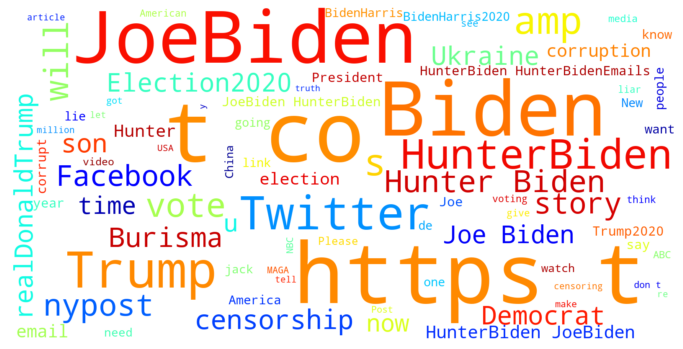

In [30]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(Biden_dataset['tweet'][0:1000])

Here we can see according to the sentiment analysis of tweets

DONALD TRUMP got 39.8% positive tweets 

JOE BIDEN got 45.5% positive tweets 

So you guys say WHO WON IN US PRESIDENT ELECTIONS 2020 according to tweets! 😄